# Connect google drive

In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Google Drive
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Mask-Or-No-Mask'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Personal_Dataset', 'Models', '.DS_Store', '.git', '.gitattributes', '.idea', 'Labs', 'readme.md', 'dataset_as_pkl', '.gitignore', 'test_function.ipynb']


# Import Libraries

In [3]:
# Imports
import os
import pickle
import numpy as np
import cv2
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, cohen_kappa_score, log_loss
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Directories

In [4]:
# -------------------------- Paths for PyCharm --------------------------
# Training paths

# SAVE_DIR = "../dataset_as_pkl"
# TRAIN_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_train.pkl"
# VAL_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_val.pkl"
# TRAIN_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_train.pkl"
# VAL_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_val.pkl"
# TEST_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_test.pkl"
# TEST_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_test.pkl"
# DATASET_PATH = "../CW_Dataset"
# TRAIN_IMAGE_PATH = "../CW_Dataset/train/images"
# TRAIN_LABEL_PATH = "../CW_Dataset/train/labels"
# HOG_TRAIN_PATH = "../dataset_as_pkl/hog_train.pkl"
# HOG_VAL_PATH = "../dataset_as_pkl/hog_val.pkl"
# SIFT_TRAIN_PATH = "../dataset_as_pkl/sift_train.pkl"
# SIFT_VAL_PATH = "../dataset_as_pkl/sift_val.pkl"

# # Testing paths

# TEST_IMAGE_PATH = "../CW_Dataset/test/images"
# TEST_LABEL_PATH = "../CW_Dataset/test/labels"

# # Model paths
# MODEL_PATH = "../Models"
# MODEL_METRICS_PATH = "../Models/Model_metrics"
# HOG_SVM_MODEL = "../Models/hog_svm_model.pkl"
# HOG_SVM_METRICS = "../Models/Model_metrics/hog_svm_metrics.pkl"
# SIFT_HOG_MODEL = "../Models/hog_sift_mlp_model.pkl"
# SIFT_HOG_METRICS = "../Models/Model_metrics/hog_sift_metrics.pkl"
# SIFT_HOG_SCALER = "../Models/hog_sift_mlp_scaler.pkl"
# CNN_MODEL = "../Models/CNN_model.pt"
# CNN_METRICS = "../Models/Model_metrics/CNN_metrics.pkl"

# ^^------------------------ Paths for PyCharm ------------------------^^

# -------------------------- Paths for Colab --------------------------
# Colab root paths

ORIGINAL_DATASET = "/content/drive/MyDrive/Mask-Or-No-Mask/CW_Dataset"
DATASET_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/dataset_as_pkl"
MODEL_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/Models"
MODEL_METRICS_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/Models/Model_metrics"

# Training Paths

SAVE_DIR = DATASET_PATH
TRAIN_FLOAT32_PATH = f"{DATASET_PATH}/normalized_float32_train.pkl"
VAL_FLOAT32_PATH = f"{DATASET_PATH}/normalized_float32_val.pkl"
TRAIN_UINT8_PATH = f"{DATASET_PATH}/normalized_uint8_train.pkl"
VAL_UINT8_PATH = f"{DATASET_PATH}/normalized_uint8_val.pkl"
TEST_FLOAT32_PATH = f"{DATASET_PATH}/normalized_float32_test.pkl"
TEST_UINT8_PATH = f"{DATASET_PATH}/normalized_uint8_test.pkl"
TRAIN_IMAGE_PATH = f"{ORIGINAL_DATASET}/train/images"
TRAIN_LABEL_PATH = f"{ORIGINAL_DATASET}/train/labels"
HOG_TRAIN_PATH = f"{DATASET_PATH}/hog_train.pkl"
HOG_VAL_PATH = f"{DATASET_PATH}/hog_val.pkl"
SIFT_TRAIN_PATH = f"{DATASET_PATH}/sift_train.pkl"
SIFT_VAL_PATH = f"{DATASET_PATH}/sift_val.pkl"

# Testing paths

TEST_IMAGE_PATH = f"{ORIGINAL_DATASET}/test/images"
TEST_LABEL_PATH = f"{ORIGINAL_DATASET}/test/labels"

# Model paths

HOG_SVM_MODEL = f"{MODEL_PATH}/hog_svm_model.pkl"
HOG_SVM_METRICS = f"{MODEL_METRICS_PATH}/hog_svm_metrics.pkl"
SIFT_HOG_MODEL = f"{MODEL_PATH}/hog_sift_mlp_model.pkl"
SIFT_HOG_METRICS = f"{MODEL_METRICS_PATH}/hog_sift_mlp_metrics.pkl"
SIFT_HOG_SCALER = f"{MODEL_METRICS_PATH}/hog_sift_mlp_scaler.pkl"
CNN_MODEL = f"{MODEL_PATH}/CNN_model.pt"
CNN_METRICS = f"{MODEL_METRICS_PATH}/CNN_metrics.pkl"

# ^^------------------------ Paths for Colab ------------------------^^


# Preprocessing

In [5]:
# Load Dataset
def load_dataset(image_dir, label_dir, valid_ext=".jpeg"):
    # Create array to store images and labels
    image_label_pairs = []

    # Iterate through all images in dataset
    for img_file in os.listdir(image_dir):
        # Skip invalid images
        if not img_file.lower().endswith(valid_ext):
            continue
        # Point to images
        img_path = os.path.join(image_dir, img_file)

        # Point to corresponding label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)

        # Skip if no label
        if not os.path.exists(label_path):
            continue

        # Read label
        with open(label_path, 'r') as f:
            label_string = f.read().strip()

        # Skip of invalid label
        if label_string not in ['0', '1', '2']:
            continue

        # Convert label (string) to int
        label = int(label_string)
        # Save image and label as tuple
        image_label_pairs.append((img_path, label))

    return image_label_pairs

# Resize images and add padding
def resize_with_padding(img, target_size=(64, 64), pad_colour=0):
    # Get image height and width
    h, w = img.shape[:2]
    # Target height and width
    th, tw = target_size

    # Set interpolation function based downscaling or upscaling
    interpolation = cv2.INTER_AREA if h > th or w > tw else cv2.INTER_CUBIC

    # Calculate aspect ratio of input image and maintain it for maintaining that aspect ratio
    aspect_ratio = float(h) / float(w)
    if aspect_ratio > 1:
        new_w = tw
        new_h = int(new_w / aspect_ratio)
    else:
        new_h = th
        new_w = int(new_h * aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=interpolation)

    # Calculate amount of padding needed, and keeping image centered
    pad_top = (th - new_h) // 2
    pad_bottom = th - new_h - pad_top
    pad_left = (tw - new_w) // 2
    pad_right = tw - new_w - pad_left

    # Add the padding (chosen colour is black)
    padded_image = cv2.copyMakeBorder(resized_img, pad_top, pad_bottom, pad_left, pad_right, borderType = cv2.BORDER_CONSTANT, value = pad_colour)

    # For SIFT and ORB especially, still works with others
    padded_image = np.clip(padded_image, 0, 255).astype(np.uint8)

    return padded_image

# Normalize pixel values and save as uint8
def resize_and_normalize_uint8(image_label_pairs, target_size=(64, 64)):
    X, y = [], []
    for img_path, label in image_label_pairs:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        padded = resize_with_padding(img, target_size)
        X.append(padded)  # uint8
        y.append(label)
    return X, y

# Normalize pixel values and save as float32
def resize_and_normalize_float32(image_label_pairs, target_size=(64, 64)):
    X, y = [], []
    for img_path, label in image_label_pairs:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        padded = resize_with_padding(img, target_size)
        normalized = padded.astype(np.float32) / 255.0
        X.append(normalized)
        y.append(label)
    return X, y

# Save using pickle
def save_as_pkl(X, y, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "wb") as f:
        pickle.dump((X, y), f)

In [6]:
# Run all preprocessing

print("Starting preprocessing...")
# Load image/label pairs
train_pairs = load_dataset(TRAIN_IMAGE_PATH, TRAIN_LABEL_PATH)
test_pairs = load_dataset(TEST_IMAGE_PATH, TEST_LABEL_PATH)

print(f"Loaded {len(train_pairs)} training and {len(test_pairs)} test images")

# Split train into train + val
train_pairs_split, val_pairs_split = train_test_split(
    train_pairs, test_size=0.2, random_state=42, stratify=[label for _, label in train_pairs]
)
print(f"Split into {len(train_pairs_split)} training and {len(val_pairs_split)} validation")

# float32 - For HOG
X_train_f32, y_train_f32 = resize_and_normalize_float32(train_pairs_split)
X_val_f32, y_val_f32 = resize_and_normalize_float32(val_pairs_split)
X_test_f32, y_test_f32 = resize_and_normalize_float32(test_pairs)

save_as_pkl(X_train_f32, y_train_f32, os.path.join(SAVE_DIR, "normalized_float32_train.pkl"))
save_as_pkl(X_val_f32, y_val_f32, os.path.join(SAVE_DIR, "normalized_float32_val.pkl"))
save_as_pkl(X_test_f32, y_test_f32, os.path.join(SAVE_DIR, "normalized_float32_test.pkl"))

print("Saved datasets as float32")

# uint8 - For everything else
X_train_uint8, y_train_uint8 = resize_and_normalize_uint8(train_pairs_split)
X_val_uint8, y_val_uint8 = resize_and_normalize_uint8(val_pairs_split)
X_test_uint8, y_test_uint8 = resize_and_normalize_uint8(test_pairs)

save_as_pkl(X_train_uint8, y_train_uint8, os.path.join(SAVE_DIR, "normalized_uint8_train.pkl"))
save_as_pkl(X_val_uint8, y_val_uint8, os.path.join(SAVE_DIR, "normalized_uint8_val.pkl"))
save_as_pkl(X_test_uint8, y_test_uint8, os.path.join(SAVE_DIR, "normalized_uint8_test.pkl"))

print("Saved datasets as uint8")
print(f"All datasets saved to .pkl in {SAVE_DIR} \n")

Starting preprocessing...


KeyboardInterrupt: 

# Feature Extraction

In [7]:
# Pickle helper functions
def save_features(filepath, features, labels):
    with open(filepath, "wb") as f:
        pickle.dump((features, labels), f)

def load_features(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)

"""
HOG and SIFT extraction was adapted based on code from Lab 5 (HOG) and Lab 6 (SIFT)
"""

# Extract HOG features
# Adapted from Lab 5
def get_hog_features(dataset_name, input_path, save_path=None):
    X, y = load_features(input_path)
    hog_features = []

    for image in X:
        # Taken from Lab 5
        HOG_des, _ = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(8, 8), block_norm="L2-Hys", visualize=True)
        hog_features.append(HOG_des)

    save_features(save_path, hog_features, y)

    return np.array(hog_features)

# Extract SIFT features
# Adapted from Lab 6
def get_sift_features(dataset_name, input_path, save_path_sift):
    # Load from uint8 .pkl dataset (used for keypoint descriptors)
    X, y = load_features(input_path)

    sift = cv2.SIFT_create()

    sift_features, sift_labels = [], []

    for i, img in enumerate(X):
        # SIFT
        kp, sift_desc = sift.detectAndCompute(img, None) # SIFT taken from lab 6
        sift_features.append(sift_desc)
        sift_labels.append(y[i])

    save_features(save_path_sift, sift_features, sift_labels)

    return sift_features, sift_labels

# Extract ORB features
def get_orb_features(dataset_name, input_path, save_path_orb):
    # Load from uint8 .pkl dataset (used for keypoint descriptors)
    X, y = load_features(input_path)

    orb = cv2.ORB_create()

    sift_features, sift_labels = [], []
    orb_features, orb_labels = [], []

    for i, img in enumerate(X):
        # ORB
        kp, orb_desc = orb.detectAndCompute(img, None)
        orb_features.append(orb_desc)
        orb_labels.append(y[i])

    save_features(save_path_orb, orb_features, orb_labels)

    return orb_features, orb_labels

In [8]:
os.makedirs(SAVE_DIR, exist_ok=True)

print("Feature extraction started")

# Extract HOG
print("Extracting HOG features in train set")
get_hog_features("train", TRAIN_FLOAT32_PATH, os.path.join(SAVE_DIR, "hog_train.pkl"))
print("Extracting HOG features in validation set")
get_hog_features("val", VAL_FLOAT32_PATH, os.path.join(SAVE_DIR, "hog_val.pkl"))
print("Extracting HOG features in test set")
get_hog_features("val", TEST_FLOAT32_PATH, os.path.join(SAVE_DIR, "hog_test.pkl"))

print(f"HOG features saved")

# Extract SIFT
print("Extracting SIFT features in train set")
get_sift_features("train", TRAIN_UINT8_PATH, os.path.join(SAVE_DIR, "sift_train.pkl"))
print("Extracting SIFT features in validation set")
get_sift_features("val", VAL_UINT8_PATH, os.path.join(SAVE_DIR, "sift_val.pkl"))
print("Extracting SIFT features in test set")
get_sift_features("test", TEST_UINT8_PATH, os.path.join(SAVE_DIR, "sift_test.pkl"))
print ("SIFT features saved")

# Extract ORB
print("Extracting ORB features in train set")
get_orb_features("train", TRAIN_UINT8_PATH, os.path.join(SAVE_DIR, "orb_train.pkl"))
print("Extracting ORB features in validation set")
get_orb_features("val", VAL_UINT8_PATH, os.path.join(SAVE_DIR, "orb_val.pkl"))
print("Extracting ORB features in test set")
get_orb_features("test", TEST_UINT8_PATH, os.path.join(SAVE_DIR, "orb_test.pkl"))
print("ORB features saved")

print("Extracting features complete")

Feature extraction started
Extracting HOG features in train set


KeyboardInterrupt: 

# Train HOG + SVM model

In [ ]:
def train_and_evaluate_svm(X_train, y_train, X_val, y_val):
    start_time = time.time()

    # Used RandomizedSearchCV to find optimal hyperparameters for model
    # Commented out so that it can be run faster now (Randomized search took 25 minutes)

    # param_dist = {
    #     "C": [0.01, 0.1, 1, 10, 100],
    #     "kernel": ["linear", "rbf"],
    #     "gamma": ["scale", "auto", 0.01, 0.001]
    # }

    # model = RandomizedSearchCV(
    #     estimator=SVC(),
    #     param_distributions=param_dist,
    #     n_iter=6,  # number of random combinations to try
    #     cv=5,
    #     scoring='accuracy',
    #     n_jobs=-1,
    #     verbose=2,
    #     random_state=42
    # )

    # Hyperparameters used now are based on best result from RandomizedSearchCV
    model = SVC(kernel='linear', C=1.0, gamma='scale')
    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    # best_model = random.search.best_estimator_

    # Define and measure metrics
    # y_pred = best_model.predict(X_val)
    inference_start_time = time.time()
    y_pred = model.predict(X_val)
    inference_time = time.time() - inference_start_time
    accuracy = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    kappa_score = cohen_kappa_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    return model, {
        "accuracy": accuracy,
        "confusion_matrix": cm.tolist(),
        "classification_report": report,
        "training_time": training_time,
        "inference_time": inference_time,
        "kappa_score": kappa_score,
        "f1_score": f1,
        # "best_params": model.best_params_
        # "cv_results": model.best_results_
    }

def save_model_and_metrics(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


In [ ]:
# Load features
print("Loading HOG features")
X_train, y_train = load_features(HOG_TRAIN_PATH)
X_val, y_val = load_features(HOG_VAL_PATH)

# Create trained model and metrics
print("Training SVM...")
svm_model, metrics = train_and_evaluate_svm(X_train, y_train, X_val, y_val)

print(f"Training took {metrics['training_time']:.2f} seconds")
print(f"Validation Accuracy: {metrics['accuracy']:.4f}")

# Save the model
print(f"Saving model to {HOG_SVM_MODEL}")
save_model_and_metrics(svm_model, HOG_SVM_MODEL)

# Save the metrics
print(f"Saving metrics to {MODEL_METRICS_PATH}")
save_model_and_metrics(metrics, HOG_SVM_METRICS)

print("Model 1: HOG + SVM training complete")

# Train HOG + SIFT + MLP model

In [ ]:
# Pickle helper function
def save_model_and_metrics(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

# Combine HOG and SIFT metrics for training
def combine_hog_sift(hog_input, sift_input):
    X_hog, y = hog_input
    X_sift, y = sift_input

    # SIFT data needs to be 128D descriptor so MLP can use it
    X_sift = [np.mean(x, axis=0) if x is not None else np.zeros(128) for x in X_sift]
    X_sift = np.stack(X_sift)
    X_hog = np.array(X_hog)

    combined_descriptors = np.concatenate([X_hog, X_sift], axis=1)
    return combined_descriptors, np.array(y)

# Train HOG + SIFT + MLP model
def train_and_evaluate_mlp():
    start_time = time.time()

    X_train, y_train = combine_hog_sift(load_features(HOG_TRAIN_PATH),
                                        load_features(SIFT_TRAIN_PATH))

    X_val, y_val = combine_hog_sift(load_features(HOG_VAL_PATH),
                                    load_features(SIFT_VAL_PATH))

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Again RandomizedSearchCV was used, but now commented out so that it runs faster
    # Best Params: {'solver': 'lbfgs', 'momentum': 0.95,
    #              'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes':
    #              (256, 128, 64), 'alpha': 0.01, 'activation': 'relu'}
    mlp_model = MLPClassifier(solver="lbfgs",
                              momentum = 0.95,
                              learning_rate_init = 0.1,
                              learning_rate= "adaptive",
                              alpha=0.01,
                              hidden_layer_sizes=(256, 128, 64),
                              activation="relu",)

    mlp_model.fit(X_train, y_train)

    # Define and measure metrics
    inference_start_time = time.time()
    y_pred = mlp_model.predict(X_val)
    inference_time = time.time() - inference_start_time
    f1 = f1_score(y_val, y_pred, average="macro")
    kappa_score = cohen_kappa_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    # param_dist = {
    #     'hidden_layer_sizes': [(256,), (128, 64), (256, 128, 64)],
    #     'activation': ['relu', 'tanh'],
    #     'alpha': [1e-5, 1e-4, 1e-3],
    #     'solver': ['adam', 'lbfgs']
    # }
    #
    # random_search = RandomizedSearchCV(
    #     estimator=MLPClassifier(max_iter=500, random_state=42),
    #     param_distributions=param_dist,
    #     n_iter=10,
    #     cv=3,
    #     verbose=2,
    #     n_jobs=-1,
    #     scoring='accuracy',
    #     random_state=42
    # )
    # print("Running RandomizedSearchCV for MLP...")
    # random_search.fit(X_train, y_train)
    #
    # mlp_model = random_search.best_estimator_
    # print("Best Params:", random_search.best_params_)
    #
    # y_pred = mlp_model.predict(X_val)


    # Save the metrics using a dictionary
    metrics = {
        "accuracy": accuracy,
        "confusion_matrix": cm.tolist(),
        "classification_report": report,
        "training_time": time.time() - start_time,
        "inference_time": inference_time,
        "f1": f1,
        "kappa_score": kappa_score,
        # "best_params": random_search.best_params_,
    }

    # Save model
    save_model_and_metrics(mlp_model, SIFT_HOG_MODEL)

    # Save metrics
    save_model_and_metrics(metrics, SIFT_HOG_METRICS)

    # Save scaler
    save_model_and_metrics(scaler, SIFT_HOG_SCALER)

In [ ]:
# Run HOG + SIFT : MLP training function
train_and_evaluate_mlp()

# CNN

In [13]:
# Path to save the training logs
log_file_path = "/content/drive/MyDrive/Mask-Or-No-Mask/Models/training_log.md"

# Each time a model is trained, name is incremented to avoid saving over last
def get_incremented_filename(base_path, base_name, extension):
    os.makedirs(base_path, exist_ok=True)
    existing = [f for f in os.listdir(base_path) if f.startswith(base_name) and f.endswith(extension)]

    if not existing:
        return os.path.join(base_path, f"{base_name}_1{extension}")

    numbers = [
        int(f[len(base_name) + 1:-len(extension)])
        for f in existing
        if f[len(base_name):].startswith("_") and f[:-len(extension)].split("_")[-1].isdigit()
    ]

    next_num = max(numbers) + 1 if numbers else 1
    return os.path.join(base_path, f"{base_name}_{next_num}{extension}")

# Helper function to load dataset using pickle
def load_features(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)

# Automatically get class weights because they are so imbalanced
# 0, No Mask: 301 images
# 1, Mask: 1552 images
# 2, Improper Mask: 62 images
def get_class_weights(train_labels):
    classes = np.unique(train_labels)
    weights = compute_class_weight(class_weight = "balanced", classes = classes, y = train_labels)
    return torch.tensor(weights, dtype = torch.float32)

# Define my CNN architecture
def my_CNN(dropout_rate = 0.01):
    class face_mask_CNN(nn.Module):
        def __init__(self, num_classes = 3):
            super(face_mask_CNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, num_classes),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return face_mask_CNN()

# Custom dataset class because I saved the dataset to a .pkl file
# Did this because colab would take forever to load all the images 1 by 1
class load_from_pkl(Dataset):
    def __init__(self, data_path, transform = None):
        self.X, self.y = load_features(data_path)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx].reshape(1,64,64)
        img = torch.tensor(img, dtype = torch.float32)
        label = torch.tensor(self.y[idx], dtype = torch.long)
        if self.transform:
            img = self.transform(img)

        return img, label

# Load the data and set augmentation for training
def get_Data(train_path, val_path, batch_size = 64):

    # Data augmentation
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(64, scale=(0.9, 1.0)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
    ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

    # Create dataset objects with the augmentation
    train_dataset = load_from_pkl(train_path, transform = train_transform)
    val_dataset = load_from_pkl(train_path, transform = val_transform)

    # Load augmented dataset
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    print("Training class distribution: ", Counter(load_from_pkl(TRAIN_FLOAT32_PATH).y))
    print("Validation class distribution: ", Counter(load_from_pkl(VAL_FLOAT32_PATH).y))


    return train_loader, val_loader

# MixUp to help fix my lack of generalization
def mixup_data(x, y, alpha = 0.1):
  if alpha > 0:
    lam = np.random.beta(alpha, alpha)
  else:
    lam = 1
  batch_size = x.size()[0]
  index = torch.randperm(batch_size)
  mixed_x = lam * x + (1 - lam) * x[index, :]
  y_a, y_b = y, y[index]
  return mixed_x, y_a, y_b, lam

# Train just 1 epoch - better flexibility
# Using MixUp is optional too
def train_single_epoch(model, dataloader, optimizer, criterion, device, use_mixup = False, alpha = 0.4):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha)
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(dataloader)
    return average_loss

# Evaluate the performance of my model
def CNN_metrics(model, dataloader, criterion, device):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    total_loss = 0.0

    inference_start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim = 1)
            preds = torch.argmax(probs, dim = 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    f1 = f1_score(y_true, y_pred, average = "macro")
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    logloss = log_loss(y_true, y_probs)
    inference_time = time.time() - inference_start_time

    cm_raw = confusion_matrix(y_true, y_pred)
    cm_normalized = cm_raw.astype('float') / cm_raw.sum(axis=1, keepdims=True)

    return {
        "accuracy": acc,
        "kappa": kappa,
        "log_loss": logloss,
        "val_loss": avg_loss,
        "cm_raw": cm_raw,
        "cm_normalized": cm_normalized,
        "inference_time": inference_time,
        "f1": f1,
    }

# Save my CNN
def save_CNN(model, path = CNN_MODEL):
    os.makedirs(os.path.dirname(path), exist_ok = True)
    torch.save(model.state_dict(), path)

# Save the metrics for my CNN
def save_CNN_metrics(metrics, path = CNN_METRICS):
    os.makedirs(os.path.dirname(path), exist_ok = True)
    with open(path, "wb") as f:
        pickle.dump(metrics, f)

# Main training function for my CNN
def train_face_mask_CNN(train_loader, val_loader, num_epochs = 10, learning_rate=0.01,
                        weight_decay = 0.0001, optimizer_type = "adamw", dropout_rate = 0.01,
                        momentum = 0.9, batch_size = 64,
                        model_save_path = CNN_MODEL,
                        metrics_save_path = CNN_METRICS,
                        early_stop_limit = 12,
                        change_description = "",
                        mixup_alpha = 0.01,
                        mixup_start_epoch = 10,
                        use_mixup = True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create / find the save path for my model
    model_save_path = get_incremented_filename(
    base_path=os.path.dirname(model_save_path),
    base_name=os.path.splitext(os.path.basename(model_save_path))[0],
    extension=".pt"
    )

    model = my_CNN(dropout_rate=dropout_rate).to(device)

    # Optimizer choice
    if optimizer_type.lower() == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov = True)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,
    div_factor=10,
    final_div_factor=100)

    # Set the class weights to help with imbalance
    class_weights = torch.tensor([1.0, 0.25, 4.0], dtype = torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    best_metrics = {}
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        use_mix = use_mixup and (epoch >= mixup_start_epoch)
        train_loss = train_single_epoch(model, train_loader, optimizer, criterion, device, use_mixup = use_mix, alpha = mixup_alpha)
        train_losses.append(train_loss)
        print(f"Train loss: {train_loss:.4f}")

        metrics = CNN_metrics(model, val_loader, criterion, device)
        val_losses.append(metrics["val_loss"])

        print(f"Accuracy: {metrics['accuracy']:.4f} | " f"Kappa: {metrics['kappa']:.4f} | " f"F1 Score: {metrics['f1']:.4f} | " f"Val Loss: {metrics['val_loss']:.4f}")


        if (metrics["accuracy"] > best_metrics.get("accuracy", 0)) or \
            (metrics["accuracy"] == best_metrics.get("accuracy", 0) and metrics["val_loss"] < best_metrics.get("val_loss", float("inf"))):

            best_val_loss = metrics["val_loss"]
            best_metrics = metrics
            best_epoch = epoch + 1
            save_CNN(model, model_save_path)
            print("Best model saved")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_limit:
          break

        scheduler.step()

    save_CNN_metrics(best_metrics, metrics_save_path)
    print("Metrics for model saved")
    print("Training complete")
    print(f"Best model was from epoch {best_epoch}")
    print(f"Best Accuracy: {best_metrics['accuracy']:.4f} | "
      f"Kappa: {best_metrics['kappa']:.4f} | "
      f"Val Loss: {best_metrics['val_loss']:.4f}")

    # Save the metrics used to train the model as dictionary
    log_entry = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_path": model_save_path,
    "dropout_rate": dropout_rate,
    "learning_rate": learning_rate,
    "batch_size": train_loader.batch_size,
    "num_epochs": num_epochs,
    "early_stopping_patience": early_stop_limit,
    "early_stop_epoch": best_epoch,
    "augmentation": True,
    "best_accuracy": best_metrics['accuracy'],
    "best_kappa": best_metrics['kappa'],
    "best_val_loss": best_metrics['val_loss'],
    "final_train_loss": train_losses[best_epoch - 1],
    "change_description": change_description,
    "weight_decay": weight_decay,
    "optimizer": optimizer_type.lower(),
    "class_weights": class_weights.tolist(),
    "f1": best_metrics['f1'],
    "learning_rate_schedule": f"StepLR(step_size=20, gamma=0.5)",
    "mixup": True,
    "mixup_alpha": 0.4,
    "log_mixup_start_epoch": mixup_start_epoch,
    "log_mixup_alpha": mixup_alpha,
    }

    # Save the metrics in a markdown format for quick access and readability
    os.makedirs(os.path.dirname(log_file_path), exist_ok = True)
    with open(log_file_path, "a") as f:
        f.write(f"### Run on {log_entry['timestamp']}\n")
        f.write(f"- **Model File**: `{log_entry['model_path']}`\n")
        f.write(f"- **Dropout**: `{log_entry['dropout_rate']}`\n")
        f.write(f"- **Learning Rate**: `{log_entry['learning_rate']}`\n")
        f.write(f"- **Batch Size**: `{log_entry['batch_size']}`\n")
        f.write(f"- **Early Stopping**: `{log_entry['early_stopping_patience']}` epochs\n")
        f.write(f"- **Stopped at Epoch**: `{log_entry['early_stop_epoch']}`\n")
        f.write(f"- **Best Accuracy**: `{log_entry['best_accuracy']:.4f}`\n")
        f.write(f"- **Best Kappa**: `{log_entry['best_kappa']:.4f}`\n")
        f.write(f"- **Best Val Loss**: `{log_entry['best_val_loss']:.4f}`\n")
        f.write(f"- **Final Train Loss**: `{log_entry['final_train_loss']:.4f}`\n")
        f.write(f"- **Augmentation**: `{log_entry['augmentation']}`\n")
        f.write(f"- **Weight Decay (L2)**: `{weight_decay}`\n")
        f.write(f"- **Optimizer**: `{log_entry['optimizer']}`\n")
        f.write(f"- **Scheduler**: None \n")
        f.write(f"- **Change Summary**: {log_entry['change_description']}\n")
        f.write(f"- **Class Weights**: `{log_entry['class_weights']}`\n")
        f.write(f"- **F1 Score**: `{log_entry['f1']:.4f}`\n")
        f.write(f"- **MixUp**: `{log_entry['mixup']}` (alpha={log_entry['mixup_alpha']})\n")
        f.write(f"- **MixUp**: `{log_entry['mixup']}` (alpha={log_entry['log_mixup_alpha']}, start_epoch={log_entry['log_mixup_start_epoch']})\n")
        f.write("---\n\n")

    # Graph to visualize Training vs Validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Change(s) made in this version: Augmentation was never working - it is now
Training class distribution:  Counter({1: 1552, 0: 301, 2: 62})
Validation class distribution:  Counter({1: 388, 0: 75, 2: 16})
Epoch 1/100
Train loss: 0.7145
Accuracy: 0.8104 | Kappa: 0.0000 | F1 Score: 0.2984 | Val Loss: 0.7373
Best model saved
Epoch 2/100
Train loss: 0.6311
Accuracy: 0.8104 | Kappa: 0.0687 | F1 Score: 0.3371 | Val Loss: 0.5987
Best model saved
Epoch 3/100
Train loss: 0.6132
Accuracy: 0.8313 | Kappa: 0.2234 | F1 Score: 0.4048 | Val Loss: 0.5686
Best model saved
Epoch 4/100
Train loss: 0.5906
Accuracy: 0.8486 | Kappa: 0.3371 | F1 Score: 0.4526 | Val Loss: 0.5497
Best model saved
Epoch 5/100
Train loss: 0.5744
Accuracy: 0.8559 | Kappa: 0.3634 | F1 Score: 0.4627 | Val Loss: 0.5343
Best model saved
Epoch 6/100
Train loss: 0.5633
Accuracy: 0.8721 | Kappa: 0.4678 | F1 Score: 0.5046 | Val Loss: 0.5225
Best model saved
Epoch 7/100
Train loss: 0.5430
Accuracy: 0.8773 | Kappa: 0.4974 | F1 Score: 0.5154 

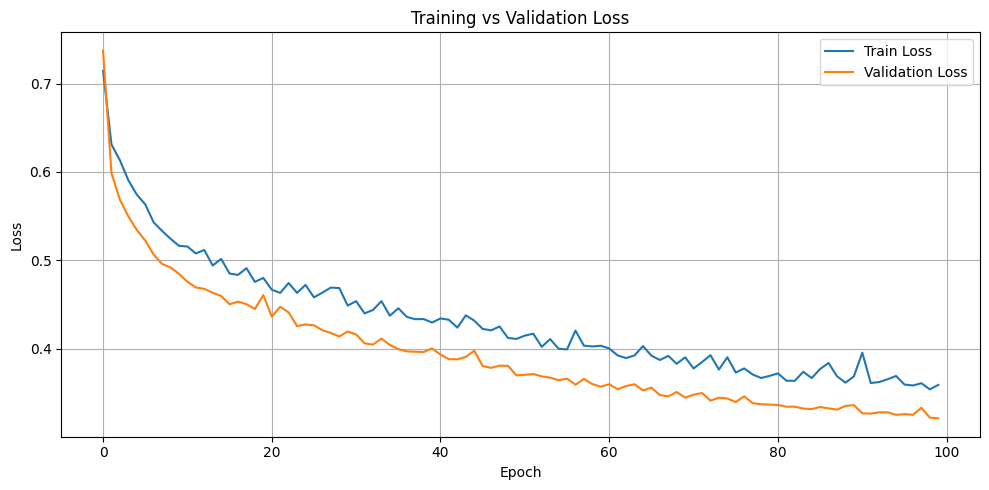

In [14]:
# Running the CNN training

# Input field so I can make a note of changes for the markdown log
change_description = input("Change(s) made in this version: ")

# Define values for the hyperparameters I want to change
batch_size = 64
dropout_rate = 0.3
learning_rate = 0.001
weight_decay = 0.001
optimizer_type = "sgd"
momentum = 0.95
num_epochs = 100

# Get data loaders
train_loader, val_loader = get_Data(TRAIN_FLOAT32_PATH, VAL_FLOAT32_PATH, batch_size=batch_size)

# Train the model
train_face_mask_CNN(
    train_loader = train_loader,
    val_loader = val_loader,
    num_epochs = num_epochs,
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    dropout_rate = dropout_rate,
    optimizer_type = optimizer_type,
    momentum = momentum,
    batch_size = batch_size,
    model_save_path = CNN_MODEL,
    metrics_save_path = CNN_METRICS,
    change_description = change_description
)